# 图像分割与Watershed算法

### 目标

在本章中，
- 我们将学习使用分水岭算法实现基于标记的图像分割
- 我们将看到：**cv.watershed**()

### 理论

任何灰度图像都可以看作是一个地形表面，其中高强度表示山峰，低强度表示山谷。你开始用不同颜色的水(标签)填充每个孤立的山谷(局部最小值)。随着水位的上升，根据附近的山峰(坡度)，来自不同山谷的水明显会开始合并，颜色也不同。为了避免这种情况，你要在水融合的地方建造屏障。你继续填满水，建造障碍，直到所有的山峰都在水下。然后你创建的屏障将返回你的分割结果。这就是Watershed背后的“思想”。你可以访问Watershed的CMM网页，了解它与一些动画的帮助。

![](data/watershed.gif)![](data/final.gif)

但是这种方法会由于图像中的噪声或其他不规则性而产生过度分割的结果。因此OpenCV实现了一个基于标记的分水岭算法，你可以指定哪些是要合并的山谷点，哪些不是。这是一个交互式的图像分割。我们所做的是给我们知道的对象赋予不同的标签。用一种颜色(或强度)标记我们确定为前景或对象的区域，用另一种颜色标记我们确定为背景或非对象的区域，最后用`0`标记我们不确定的区域。这是我们的标记。然后应用分水岭算法。然后我们的标记将使用我们给出的标签进行更新，对象的边界值将为`-1`。

### 代码

下面我们将看到一个有关如何使用距离变换和分水岭来分割相互接触的对象的示例。

考虑下面的硬币图像，硬币彼此接触。即使你设置阈值，它也会彼此接触。

我们先从寻找硬币的近似估计开始。因此，我们可以使用Otsu的二值化。

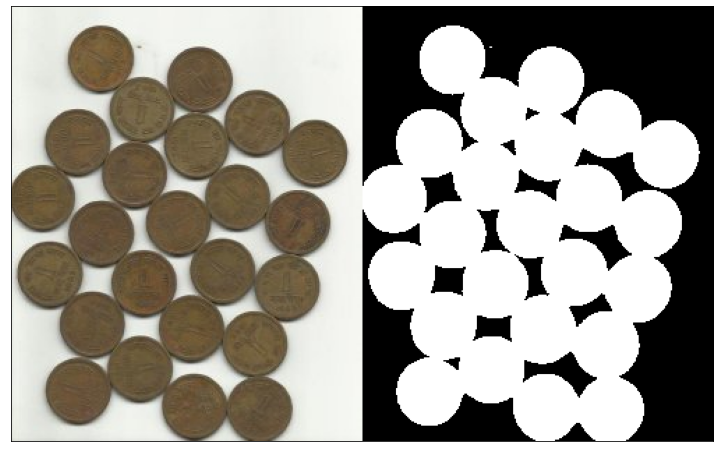

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

org = cv.imread('data/coins.jpg')
gray = cv.cvtColor(org,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

img = cv.merge((thresh, thresh, thresh))

res = np.hstack((org, img))

plt.figure(figsize=(16,8))
plt.imshow(cv.cvtColor(res,cv.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

现在我们需要去除图像中的任何白点噪声。为此，我们可以使用形态学扩张。要去除对象中的任何小孔，我们可以使用形态学侵蚀。因此，现在我们可以确定，靠近对象中心的区域是前景，而离对象中心很远的区域是背景。我们不确定的唯一区域是硬币的边界区域。

因此，我们需要提取我们可确定为硬币的区域。侵蚀会去除边界像素。因此，无论剩余多少，我们都可以肯定它是硬币。如果物体彼此不接触，那将起作用。但是，由于它们彼此接触，因此另一个好选择是找到距离变换并应用适当的阈值。接下来，我们需要找到我们确定它们不是硬币的区域。为此，我们扩张了结果。膨胀将对象边界增加到背景。这样，由于边界区域已删除，因此我们可以确保结果中背景中的任何区域实际上都是背景。参见下图。

剩下的区域是我们不知道的区域，无论是硬币还是背景。分水岭算法应该找到它。这些区域通常位于前景和背景相遇（甚至两个不同的硬币相遇）的硬币边界附近。我们称之为边界。可以通过从`sure_bg`区域中减去`sure_fg`区域来获得。

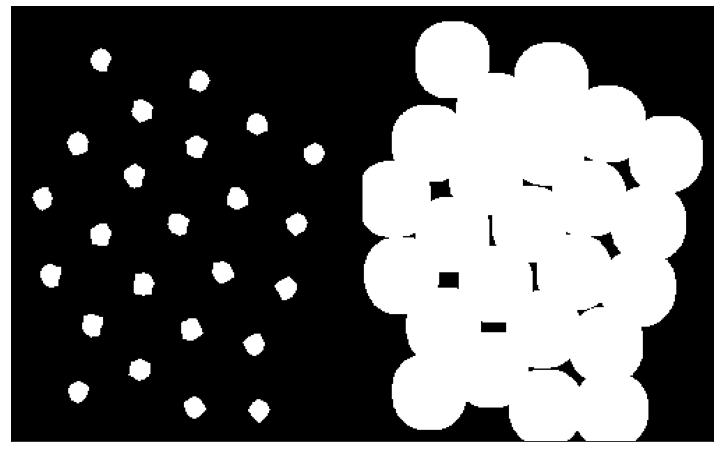

In [2]:
# 噪声去除
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)

# 确定背景区域
sure_bg = cv.dilate(opening,kernel,iterations=3)

# 寻找前景区域
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)

res1 = np.hstack((dist_transform, sure_fg))

# 找到未知区域
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

res2 = np.hstack((sure_fg, sure_bg))

plt.figure(figsize=(16,8))
plt.imshow(res2, 'gray')
plt.xticks([]), plt.yticks([])
plt.show()

查看结果。在阈值图像中，我们得到了一些硬币区域，我们确定它们是硬币，并且现在已分离它们。（在某些情况下，你可能只对前景分割感兴趣，而不对分离相互接触的对象感兴趣。在那种情况下，你无需使用距离变换，只需侵蚀就足够了。侵蚀只是提取确定前景区域的另一种方法。）



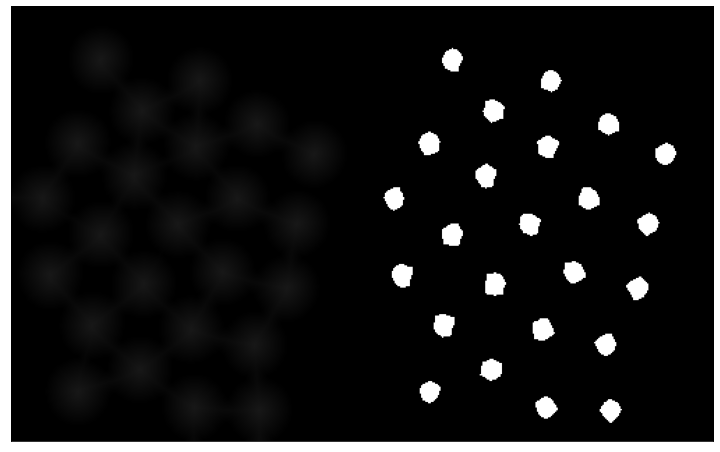

In [3]:
plt.figure(figsize=(16,8))
plt.imshow(res1, 'gray')
plt.xticks([]), plt.yticks([])
plt.show()

现在我们可以确定哪些是硬币的区域，哪些是背景。因此，我们创建了标记（它的大小与原始图像的大小相同，但具有int32数据类型），并标记其中的区域。我们肯定知道的区域（无论是前景还是背景）都标有任何正整数，但是带有不同的整数，而我们不确定的区域则保留为零。为此，我们使用**cv.connectedComponents**()。它用0标记图像的背景，然后其他对象用从1开始的整数标记。

但是我们知道，如果背景标记为0，则分水岭会将其视为未知区域。所以我们想用不同的整数来标记它。相反，我们将未知定义的未知区域标记为0。

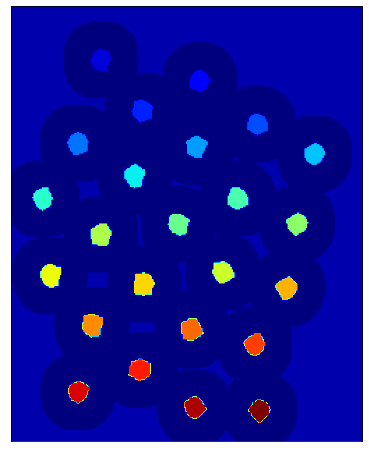

In [4]:
# 类别标记
ret, markers = cv.connectedComponents(sure_fg)

# 为所有的标记加1，保证背景是0而不是1
markers = markers+1

# 现在让所有的未知区域为0
markers[unknown==255] = 0

plt.figure(figsize=(8,8))
plt.imshow(markers, 'jet')
plt.xticks([]), plt.yticks([])
plt.show()

参见JET colormap中显示的结果。深蓝色区域显示未知区域。当然,硬币的颜色不同。剩下,肯定为背景的区域显示在较浅的蓝色，跟未知区域相比。

现在我们的标记已准备就绪。现在是最后一步的时候了，使用分水岭算法。然后标记图像将被修改。边界区域将标记为-1。

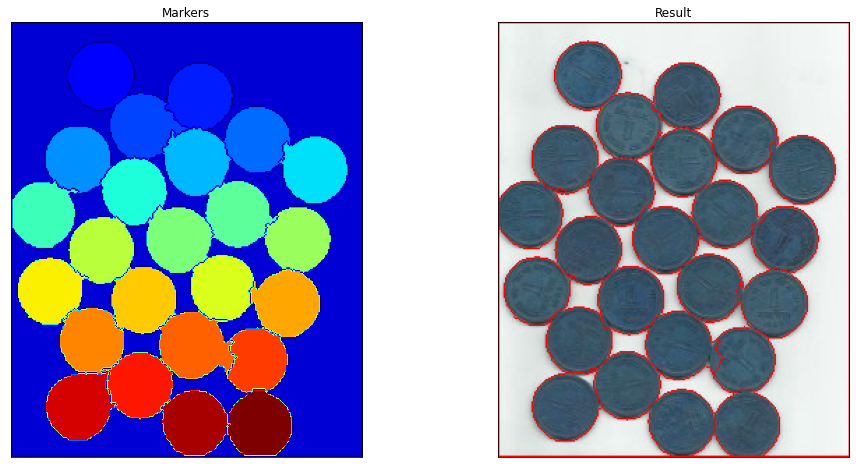

In [5]:
img = org.copy()

markers = cv.watershed(img,markers) 
img[markers == -1] = [255,0,0]

plt.figure(figsize=(16,8))
plt.subplot(121),plt.imshow(markers, cmap = 'jet')
plt.title('Markers'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img)
plt.title('Result'), plt.xticks([]), plt.yticks([])

plt.show()

对某些硬币，它们接触的区域被正确地分割，而对于某些硬币，却不是。

### 附加资源

1. CMM page on [Watershed Transformation](http://cmm.ensmp.fr/~beucher/wtshed.html)

### 练习

1. OpenCV samples has an interactive sample on watershed segmentation, watershed.py. Run it, Enjoy it, then learn it.